<span style="color: green;">

# Laboratory #4: Adversarial Learning and OOD Detection

In this laboratory session we will develop a methodology for detecting OOD samples and measuring the quality of OOD detection. We will also experiment with incorporating adversarial examples during training to render models more robust to adversarial attacks.

</span>


You have to run the following instruction to create your conda env:

- conda create --name Lab4_DLA
- conda activate Lab4_DLA
- conda install pytorch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 pytorch-cuda=11.8 -c pytorch -c nvidia
- pip install scikit-learn


In [10]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision.datasets import CIFAR10, CIFAR100
import torchvision.transforms as transforms
from torch.utils.data import Subset

import os
import matplotlib.pyplot as plt
import numpy as np

In [5]:
i = 1
if torch.cuda.is_available():
    device = torch.device("cuda:" + str(i))  # cuda:0 , cuda:1
elif torch.backends.mps.is_available():
    device = torch.device("mps")  # yes, i have a MacBookPro with M1 Pro
else:
    device = torch.device("cpu")

print(f"device: {device}")
print(
    "GPU: " + torch.cuda.get_device_name(i)
    if device == torch.device("cuda:" + str(i))
    else ""
)

device: cuda:1
GPU: NVIDIA RTX A2000 12GB


<span style="color: green;">

## Exercise 1: OOD Detection and Performance Evaluation

In this first exercise you will build a simple OOD detection pipeline and implement some performance metrics to evaluate its performance.

</span>


<span style="color: green;">

### Exercise 1.1: Build a simple OOD detection pipeline

Implement an OOD detection pipeline (like in the Flipped Activity notebook) using an ID and an OOD dataset of your choice. Some options:

- CIFAR-10 (ID), Subset of CIFAR-100 (OOD). You will need to wrap CIFAR-100 in some way to select a subset of classes that are _not_ in CIFAR-10 (see `torch.utils.data.Subset`).
- Labeled Faces in the Wild (ID), CIFAR-10 or FakeData (OOD). The LfW dataset is available in Scikit-learn (see `sklearn.datasets.fetch_lfw_people`).
- Something else, but if using images keep the images reasonably small!

In this exercise your _OOD Detector_ should produce a score representing how "out of distribution" a test sample is. We will implement some metrics in the next exercise, but for now use the techniques from the flipped activity notebook to judge how well OOD scoring is working (i.e. histograms).

**Note**: Make sure you make a validation split of your ID dataset for testing.

</span>


In [7]:
batch_size = 64
epochs = 20
lr = 0.01
val_size = 10000

In [23]:
# plot label distribution with string (cifar10 style)


def plot_hist_labels_distribution_string(data, num_classes, split, position):
    if split == "train":
        labels_train = [y for _, y in data]
        all_labels = torch.tensor([value for value in list(labels_train)]).float()
        classes = data.dataset.classes
    elif split == "val":
        labels_val = [y for _, y in data]
        all_labels = torch.tensor([value for value in list(labels_val)]).float()
        classes = data.dataset.classes
    elif split == "test":
        all_labels = torch.tensor([value for value in list(data.targets)]).float()
        classes = data.classes

    hist = torch.histc(all_labels, bins=num_classes)
    plt.subplot(1, 3, position)
    plt.bar(range(num_classes), hist, align="center")
    plt.xlabel("Labels")
    plt.ylabel("Number of Examples")
    if num_classes <= 10:
        plt.xticks(np.arange(0, num_classes, 1), classes, rotation=90)
    plt.title(split + " " + "Set Label Distribution")


# for mnist: get_normalize_values(ds_train_initial.data.float())
# for cifar10: get_normalize_values(ds_train_initial.data)


def get_normalize_values(data):
    return (
        data.mean(axis=(0, 1, 2)) / 255,
        data.std(axis=(0, 1, 2)) / 255,
    )

## ID Dataset


Files already downloaded and verified
Files already downloaded and verified
Classes: {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
N° samples train: 40000
N° samples validation: 10000
N° samples test: 10000
N° batches train: 625
N° batches val: 157
N° batches test: 157


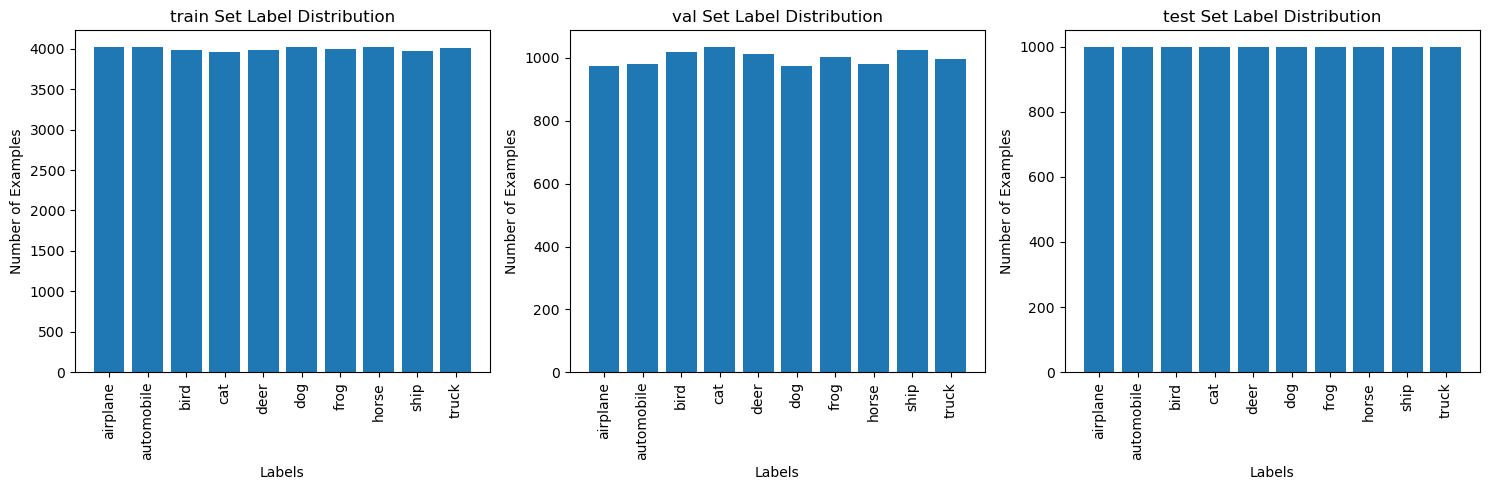

In [26]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            (0.49139968, 0.48215841, 0.44653091),
            (0.24703223, 0.24348513, 0.26158784),
        ),
    ]
)

ds_train_initial = CIFAR10(
    root="../dataset/", train=True, download=True, transform=transform
)
num_classes = len(ds_train_initial.classes)
ds_test = CIFAR10(root="../dataset/", train=False, download=True, transform=transform)

n_examples_test = len(ds_test)

print(f"Classes: {ds_train_initial.class_to_idx}")

I = np.random.permutation(len(ds_train_initial))
ds_val = Subset(ds_train_initial, I[:val_size])
n_examples_val = len(ds_val)

ds_train = Subset(ds_train_initial, I[val_size:])
n_examples_train = len(ds_train)

print(f"N° samples train: {n_examples_train}")
print(f"N° samples validation: {n_examples_val}")
print(f"N° samples test: {n_examples_test}")
# Imposta la dimensione della figura per contenere i 3 grafici in riga

plt.figure(figsize=(15, 5))

plot_hist_labels_distribution_string(ds_train, num_classes, "train", 1)
plot_hist_labels_distribution_string(ds_val, num_classes, "val", 2)
plot_hist_labels_distribution_string(ds_test, num_classes, "test", 3)

plt.tight_layout()  # Ottimizza lo spaziamento tra i grafici

dl_train = torch.utils.data.DataLoader(
    ds_train, batch_size, shuffle=True, num_workers=4
)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=False, num_workers=4)

num_batch_train = len(dl_train)
num_batch_val = len(dl_val)
num_batch_test = len(dl_test)

print(f"N° batches train: {num_batch_train}")
print(f"N° batches val: {num_batch_val}")
print(f"N° batches test: {num_batch_test}")

id_classes = ds_train_initial.classes

## OOD Dataset


Files already downloaded and verified
Classes: {'apple': 0, 'aquarium_fish': 1, 'baby': 2, 'bear': 3, 'beaver': 4, 'bed': 5, 'bee': 6, 'beetle': 7, 'bicycle': 8, 'bottle': 9, 'bowl': 10, 'boy': 11, 'bridge': 12, 'bus': 13, 'butterfly': 14, 'camel': 15, 'can': 16, 'castle': 17, 'caterpillar': 18, 'cattle': 19, 'chair': 20, 'chimpanzee': 21, 'clock': 22, 'cloud': 23, 'cockroach': 24, 'couch': 25, 'crab': 26, 'crocodile': 27, 'cup': 28, 'dinosaur': 29, 'dolphin': 30, 'elephant': 31, 'flatfish': 32, 'forest': 33, 'fox': 34, 'girl': 35, 'hamster': 36, 'house': 37, 'kangaroo': 38, 'keyboard': 39, 'lamp': 40, 'lawn_mower': 41, 'leopard': 42, 'lion': 43, 'lizard': 44, 'lobster': 45, 'man': 46, 'maple_tree': 47, 'motorcycle': 48, 'mountain': 49, 'mouse': 50, 'mushroom': 51, 'oak_tree': 52, 'orange': 53, 'orchid': 54, 'otter': 55, 'palm_tree': 56, 'pear': 57, 'pickup_truck': 58, 'pine_tree': 59, 'plain': 60, 'plate': 61, 'poppy': 62, 'porcupine': 63, 'possum': 64, 'rabbit': 65, 'raccoon': 66, 'r

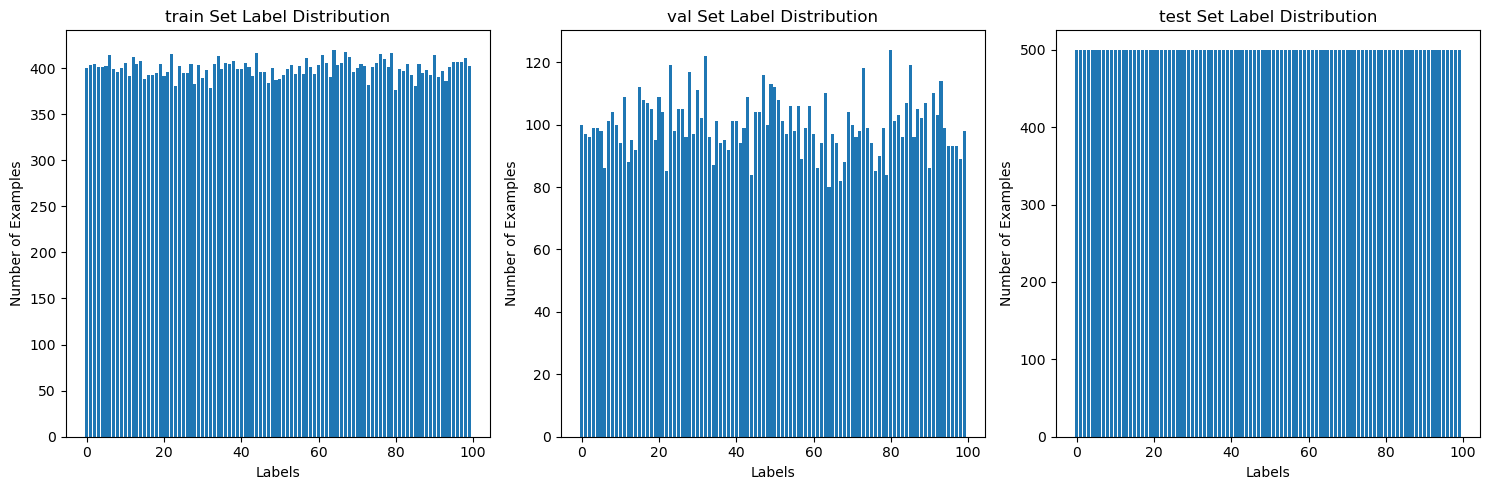

In [27]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            (0.50707516, 0.48654887, 0.44091784),
            (0.26733429, 0.25643846, 0.27615047),
        ),
    ]
)

ds_train_initial = CIFAR100(
    root="../dataset/", train=True, download=True, transform=transform
)
num_classes = len(ds_train_initial.classes)
ds_test = CIFAR100(root="../dataset/", train=True, download=False, transform=transform)

n_examples_test = len(ds_test)

print(f"Classes: {ds_train_initial.class_to_idx}")

I = np.random.permutation(len(ds_train_initial))
ds_val = Subset(ds_train_initial, I[:val_size])
n_examples_val = len(ds_val)

ds_train = Subset(ds_train_initial, I[val_size:])
n_examples_train = len(ds_train)

print(f"N° samples train: {n_examples_train}")
print(f"N° samples validation: {n_examples_val}")
print(f"N° samples test: {n_examples_test}")
# Imposta la dimensione della figura per contenere i 3 grafici in riga

plt.figure(figsize=(15, 5))

plot_hist_labels_distribution_string(ds_train, num_classes, "train", 1)
plot_hist_labels_distribution_string(ds_val, num_classes, "val", 2)
plot_hist_labels_distribution_string(ds_test, num_classes, "test", 3)

plt.tight_layout()  # Ottimizza lo spaziamento tra i grafici

dl_train = torch.utils.data.DataLoader(
    ds_train, batch_size, shuffle=True, num_workers=4
)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=False, num_workers=4)

num_batch_train = len(dl_train)
num_batch_val = len(dl_val)
num_batch_test = len(dl_test)

print(f"N° batches train: {num_batch_train}")
print(f"N° batches val: {num_batch_val}")
print(f"N° batches test: {num_batch_test}")

ood_classes = ds_train_initial.classes

In [33]:
# prendi le classi di cifar100 che non sono in cifar10
print(id_classes + ood_classes)
print(len(set(id_classes + ood_classes)))

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 't

<span style="color: green;">

### Exercise 1.2: Measure your OOD detection performance

There are several metrics used to evaluate OOD detection performance, we will concentrate on two threshold-free approaches: the area under the Receiver Operator Characteristic (ROC) curve for ID classification, and the area under the Precision-Recall curve for _both_ ID and OOD scoring. See [the ODIN paper](https://arxiv.org/pdf/1706.02690.pdf) section 4.3 for a description of OOD metrics.

Use the functions in `sklearn.metrics` to produce ROC and PR curves for your OOD detector. Some useful functions:

- [`sklearn.metric.RocCurveDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
- [`sklearn.metrics.PrecisionRecallDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)

</span>


In [3]:
# Your code here.

<span style="color: green;">

---

## Exercise 2: Enhancing Robustness to Adversarial Attack

In this second exercise we will experiment with enhancing our base model to be (more) robust to adversarial attacks.

### Exercise 2.1: Implement FGSM and generate adversarial examples

Recall that the Fast Gradient Sign Method (FGSM) perturbs samples in the direction of the gradient with respect to the input $\mathbf{x}$:
$$ \boldsymbol{\eta}(\mathbf{x}) = \varepsilon \mathrm{sign}(\nabla\_{\mathbf{x}} \mathcal{L}(\boldsymbol{\theta}, \mathbf{x}, y)) ) $$
Implement FGSM and generate some *adversarial examples* using your trained ID model. Evaluate these samples qualitatively and quantitatively. Evaluate how dependent on $\varepsilon$ the quality of these samples are.

</span>


In [4]:
# Your code here.

<span style="color: green;">

### Exercise 2.2: Augment training with adversarial examples

Use your implementation of FGSM to augment your training dataset with adversarial samples. Ideally, you should implement this data augmentation _on the fly_ so that the adversarial samples are always generated using the current model. Evaluate whether the model is more (or less) robust to ID samples using your OOD detection pipeline and metrics you implemented in Exercise 1.

</span>


In [ ]:
# Your code here.

<span style="color: green;">

---

## Exercise 3: Wildcard

You know the drill. Pick _ONE_ of the following exercises to complete.

### Exercise 3.1: Implement ODIN for OOD detection

ODIN is a very simple approach, and you can already start experimenting by implementing a temperature hyperparameter in your base model and doing a grid search on $T$ and $\varepsilon$.

### Exercise 3.2: Implement JARN

In exercise 2.2 you already implemented Jacobian-regularized learning to make your model more robust to adversarial samples. Add a _discriminator_ to your model to encourage the adversarial samples used for regularization to be more _salient_.

See [the JARN paper](https://arxiv.org/abs/1912.10185) for more details.

### Exercise 3.3: Experiment with _targeted_ adversarial attacks

Implement the targeted Fast Gradient Sign Method to generate adversarial samples that _imitate_ samples from a specific class. Evaluate your adversarial samples qualitatively and quantitatively.

</span>
